# reverse

In [1]:
import numpy as np
import torch
import yaml
import json
import resampy
import os
import sys
from glob import glob
# from stable_baselines3 import TD3
# from stable_baselines3.common.buffers import ReplayBuffer
# from stable_baselines3.common.noise import ActionNoise
# from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
# from stable_baselines3.common.policies import BaseModel, BasePolicy
# from stable_baselines3.common.torch_layers import BaseFeaturesExtractor, NatureCNN, get_actor_critic_arch
# from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
# from stable_baselines3.td3.policies import TD3Policy
from asr_api import ASR
from sb3_api import CustomDDPG
from gym_api import SpoLacq3
sys.path.append("../tools/I2U")
from models_i2u import ImageToUnit
sys.path.append("../tools/U2S")
from hparams import create_hparams
from text import text_to_sequence
from train import load_model
sys.path.append("../tools/hifi-gan")
from env import AttrDict
from inference import load_checkpoint
from models_hifi_gan import Generator
"""
An agent learn to understand and speak under an environment.
How to evaluate it?
- accuracy: the percentage of correct sentences
- fluency: the percentage of fluent sentences
- diversity: the percentage of diverse sentences
- meaning: the percentage of sentences with the same meaning
- style: the way of speaking
- voice: the voice of speaker
- emotion: the emotion of speaker
- accent: the accent of speaker
- language: the language of speaker
- rate of reward: the rate of reward
    - If agent can maximize the reward to 1, it can understand and speak.
    - If between, some sentences are correct, some are incorrect.
    - If agent can maximize the reward to 0, it cannot understand and speak.
TODO:
- Logging:
    - Image path, internal state, action (speech and transcription), and reward.
- How to test the trained agent?
    - Test it on the test set.
    - Extract those information (like image, state, action, and reward)
"""
# load the agent's brain
class Args:
    def __init__(self, word_map, u2s_config):
        self.word_map = word_map
        self.u2s_config = u2s_config
def make_action2text(config, args):
    __file__ = os.getcwd() + '/reverse.ipynb' # __file__ doesn't work in jupyter notebook
    word_map = args.word_map # custom word map
    u2s_config = args.u2s_config # custom u2s config
    assert word_map in ['default', 'word_map_20', 'word_map_100',
                        'word_map_5_hubert', 'word_map_10_hubert',
                        'word_map_20_hubert', 'word_map_100_hubert',
                        'word_map_spokencoco', 'word_map_rawfood_100']
    model_path = {
        'word_map'             : 'model_path',
        'word_map_20'          : 'model_path_20',
        'word_map_100'         : 'model_path_100',
        'word_map_5_hubert'    : 'model_path_5_hubert',
        'word_map_10_hubert'   : 'model_path_10_hubert',
        'word_map_20_hubert'   : 'model_path_20_hubert',
        'word_map_100_hubert'  : 'model_path_100_hubert',
        'word_map_rawfood_100' : 'model_path_rawfood_100',
    }[word_map]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # I2U
    word_map_path = os.path.join(os.path.dirname(__file__), "..", config["I2U"][word_map])
    image_to_unit_model_path = os.path.join(os.path.dirname(__file__), "..", config["I2U"][model_path])
    print(f'----------- model path -----------')
    print(f'model config path: {model_path}')
    print(f'model path: {image_to_unit_model_path}')
    print(f'----------------------------------')
    print(f'word map path: {word_map_path}')
    with open(word_map_path) as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}
    special_words = {"<unk>", "<start>", "<end>", "<pad>"}
    print(f'length word map: {len(word_map)}')
    image_to_unit = ImageToUnit(word_map, max_len=102)
    image_to_unit.load_state_dict(torch.load(image_to_unit_model_path))
    image_to_unit.to(device).eval()
    # U2S
    checkpoint_path = os.path.join(os.path.dirname(__file__), "..", config["U2S"][u2s_config])
    print(f'checkpoint_path: {checkpoint_path}')
    hparams = create_hparams()
    hparams.n_symbols = len(word_map) - 2
    # hparams.n_symbols = 152
    print(f'length hparams.n_symbols: {hparams.n_symbols}')
    tacotron2 = load_model(hparams)
    tacotron2.load_state_dict(torch.load(checkpoint_path)["state_dict"])
    tacotron2.to(device).eval()
    # hifi-gan
    hifi_gan_config_path = os.path.join(os.path.dirname(__file__), "..", config["HiFi_GAN"]["config"])
    hifi_gan_checkpoint_path = os.path.join(os.path.dirname(__file__), "..", config["HiFi_GAN"]["checkpoint"])
    with open(hifi_gan_config_path) as f:
        data = f.read()
    json_config = json.loads(data)
    h = AttrDict(json_config)
    generator = Generator(h).to(device)
    state_dict_g = load_checkpoint(hifi_gan_checkpoint_path, device)
    generator.load_state_dict(state_dict_g["generator"])
    # ASR
    asr_dir = os.path.join(os.path.dirname(__file__), "..", config["ASR"]["dir"])
    asr = ASR(asr_dir)
    @torch.inference_mode()
    def action2text(action):
        action = torch.from_numpy(action).unsqueeze(0).to(device)
        unit_seq = image_to_unit.infer(action=action, beam_size=config["I2U"]["beam_size"])
        words = [rev_word_map[idx] for idx in unit_seq if rev_word_map[idx] not in special_words]
        sequence = np.array(text_to_sequence(" ".join(words), ["english_cleaners"]))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).to(device).long()
        try:
            _, mel_outputs_postnet, _, _ = tacotron2.inference(sequence)
            audio = generator(mel_outputs_postnet)
            audio = audio.squeeze().cpu().numpy().astype(np.float64)
            audio = resampy.resample(audio, 22050, 16000)
            transcript = asr(audio)
            print(f'transcript: {transcript}', flush=True)
        except RuntimeError as e:
            transcript = ""
            print(e, flush=True)
        return transcript
    return action2text
def test(num_episode: int, env, model: CustomDDPG) -> None:
    """Test the learnt agent."""
    for i in range(num_episode):
        print(f"episode {i}", "-" * 40)
        state = env.reset()
        print(f'state: {state["state"]}')
        print(f'state keys: {state.keys()}')
        total_reward = 0
        while True:
            print(f"-------------- state: {state.keys} --------------")
            # render the state
            # env.render()
            # Agent gets an environment state and returns a decided action
            action, _ = model.predict(state, deterministic=True)
            print(f'action shape: {action.shape}')
            print('action', action)
            # Environment gets an action from the agent, proceeds the time step,
            # and returns the new state and reward etc.
            state, reward, done, info = env.step(action)
            total_reward += reward
            # utterance = env.dlgworld.asr(env.sounddic[action])
            # print(f"utterance: {utterance}, reward: {reward}")
            if done:
                print(f"total_reward: {total_reward}\n")
                break

/net/papilio/storage6/phusaeng/anaconda3/envs/spolacq_ryota/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load environment


In [2]:
# init args
args = Args(word_map="word_map_100_hubert", u2s_config="u2s_path_haoyuan")
with open("../conf/spolacq3.yaml") as y:
    config = yaml.safe_load(y)
action2text = make_action2text(config, args)
# load pretrained agent
model_path = "../models/RL_hubert/23-06-25_00-09-40_pikaia30_word_map_100_hubert/"
model = CustomDDPG.load(f"{model_path}best_model")
eval_env = SpoLacq3(
        glob("../data/dataset/*/test_number[12]/*.jpg"),
        d_image_features=768,
        d_embed=config["I2U"]["d_embed"],
        action2text=action2text,
    )

----------- model path -----------
model config path: model_path_100_hubert
model path: /net/papilio/storage6/phusaeng/fun/spolacq/spolacq/utils/../models/I2U/23-06-20_10-07-18_pikaia27_word_map_100_hubert_hubert_i2u_with_sentence_embedding.pt
----------------------------------
word map path: /net/papilio/storage6/phusaeng/fun/spolacq/spolacq/utils/../data/I2U/processed/precessed_phurich/komatsu_4_captions_224_hubert/WORDMAP_coco_4_cap_per_img_1_min_word_freq.json
length word map: 104
checkpoint_path: /net/papilio/storage2/yhaoyuan/transformer_I2S/saved_model/U2S/outdir_komatsu_hubert_22050/checkpoint_9000_warmstart
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

length hpara

# test state


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


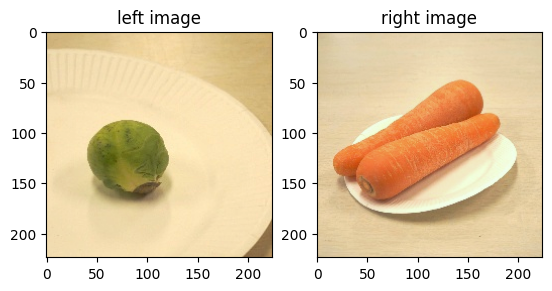

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
state = eval_env.reset()
# state['leftimage'].shape, state['rightimage'].shape # (3, 224, 224)
# plt.imshow(state['leftimage'].transpose(1, 2, 0))
# plt.imshow(img)
def norm(img):
    return (255*(img-img.min())/(img.max()-img.min())).astype(np.int16)
left_img = state['leftimage'].transpose(1, 2, 0)
right_img = state['rightimage'].transpose(1, 2, 0)
left_img = norm(left_img)
right_img = norm(right_img)
plt.subplot(1, 2, 1)
plt.imshow(left_img)
plt.title('left image')
plt.subplot(1, 2, 2)
plt.imshow(right_img)
plt.title('right image')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
(3, 224, 224)
torch.Size([3, 224, 224])


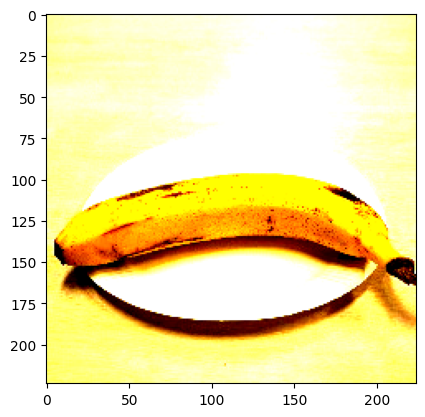

In [42]:
# just test, delete later.
from torchvision import transforms

image_list = glob("../data/dataset/*/test_number[12]/*.jpg")
sample_img = image_list[0]
pil_img = Image.open(sample_img)
np_img = np.asarray(pil_img)
print(np_img.shape)
np_img = np_img.transpose(2, 0, 1)
print(np_img.shape) 
image = torch.FloatTensor(np_img / 255.0)
print(image.shape)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Normalize(mean=mean, std=std)
image = transform(image).numpy()
plt.imshow(image.transpose(1, 2, 0))

# what is the internal state?


BANANA


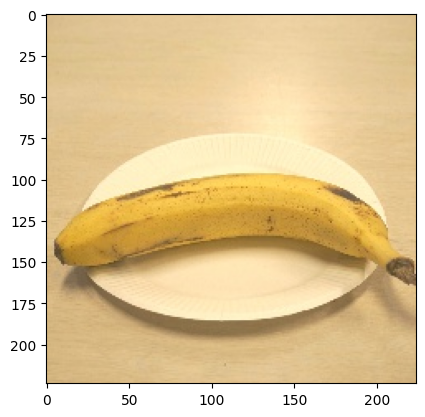

episode 0 ----------------------------------------
state: [ 0.96455176  0.17016807 -0.5146841 ]
state keys: dict_keys(['state', 'leftimage', 'rightimage'])
-------------- state: <built-in method keys of dict object at 0x7f2be0e87370> --------------
action shape: (776,)
action [ 2.42428994e+00  3.73651266e-01 -1.28103983e+00  9.07237351e-01
  3.64666224e-01 -3.58929902e-01  2.33880267e-01 -2.80529809e+00
 -1.47859454e+00 -5.67132950e-01 -2.73871690e-01 -3.10064614e-01
 -2.65341997e+00 -3.03217530e-01  3.17470837e+00  8.93155336e-01
 -3.11431980e+00  1.80696869e+00  7.99411476e-01 -1.91804123e+00
  6.13627851e-01 -1.70760167e+00 -6.71175003e-01  1.08959377e+00
  5.48185110e-01  3.49401546e+00  2.39737391e+00 -2.58562922e+00
 -6.34306431e+00 -2.26132846e+00  3.74884462e+00  9.61197019e-01
 -2.20124412e+00  2.07336521e+00  2.67766684e-01 -5.63132823e-01
 -1.72589362e+00  2.94785452e+00 -1.09698594e+00  1.80061936e+00
 -8.57204378e-01 -1.51227570e+00  2.19311523e+00  2.66014051e+00
 -7.7172

transcript: I WANT A SWEET POTATO
total_reward: 1

episode 1 ----------------------------------------
state: [-0.59380084 -1.16036415  0.13019608]
state keys: dict_keys(['state', 'leftimage', 'rightimage'])
-------------- state: <built-in method keys of dict object at 0x7f2be0d31b90> --------------
action shape: (776,)
action [ 1.04486918e+00  4.32473242e-01  1.32696891e+00  1.94298840e+00
  8.52164865e-01 -1.07008660e+00  1.30390763e+00 -4.51203167e-01
 -3.75472665e+00 -1.20701718e+00 -5.43696105e-01 -1.31391263e+00
 -2.76939487e+00 -6.04166865e-01  3.08261871e+00 -1.05177379e+00
 -2.99262595e+00  2.62772560e+00  2.66645479e+00  1.58295304e-01
  1.31843805e-01 -3.15897733e-01 -2.55757737e+00 -8.47571075e-01
  2.16508538e-01  2.77455616e+00 -1.84793544e+00 -6.67872190e-01
 -5.71405411e+00 -4.30783600e-01 -1.09319575e-01  2.11915517e+00
 -2.07738471e+00 -1.93063751e-01  1.07087576e+00 -6.60342127e-02
 -3.36153913e+00  6.00459814e+00 -1.50682139e+00 -7.62055755e-01
 -1.16262364e+00 -1.38

In [4]:
state['state']
# why motivation of the agnet is the mean of the image?
# %% ------------------------------------ test ------------------------------------
# we wanna log the image, internal state, action (speech and transcription), and reward.
# get correct transcription
image_list = glob("../data/dataset/*/test_number[12]/*.jpg")
sample_img = image_list[0] # one banana
print(sample_img.split('/')[3].upper())
plt.imshow(Image.open(sample_img))
plt.show()
# %% ------------------------------------ run environment ------------------------------------
test(
    num_episode=10,
    env=eval_env,
    model=model,
)
# ---------------------------------------------------------------------------------------------
# %%
